In [1]:
! cd ..

In [2]:
from pathlib import Path
import sys 
sys.path.append(str(Path.cwd().parents[1]))
print(sys.path)

['/Users/czyjtu/dev/cad-ml/notebooks', '/Users/czyjtu/dev/cad-ml', '/Users/czyjtu/dev/cad-ml/notebooks', '/opt/homebrew/Cellar/python@3.10/3.10.11/Frameworks/Python.framework/Versions/3.10/lib/python310.zip', '/opt/homebrew/Cellar/python@3.10/3.10.11/Frameworks/Python.framework/Versions/3.10/lib/python3.10', '/opt/homebrew/Cellar/python@3.10/3.10.11/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload', '', '/Users/czyjtu/dev/cad-ml/venv/lib/python3.10/site-packages', '/opt/homebrew/opt/python-tk@3.10/libexec', '/Users/czyjtu/dev']


In [3]:
from cadml.datamodules.roi_classification import ROIClassificationDataModule, ROIClassificationDataset
import coronaryx as cx
import coronaryx.algorithms as cxa
import coronaryx.functions as cxf
from coronaryx.data import CoronagraphyScan, VesselBranch, ROI
import torch as th 
import torchvision as tv
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt 


# load checkpoint 

In [5]:
import pytorch_lightning as pl 
from cadml.models.resnet import ResNet 
from cadml.tasks.roi_classification_task import ROIClassificationTask
import torch as th 
from copy import deepcopy 

ckpt_path = "/Users/czyjtu/dev/cad-ml/cad-resnet-icy-sweep-12-epoch=195-f1=0.7015.ckpt"
checkpoint = th.load(ckpt_path, map_location=th.device('cpu'))
cfg = checkpoint['hyper_parameters']
model_ = ResNet(cfg)
weights = deepcopy(list(model_.parameters()))

model = ROIClassificationTask(cfg, model_)
model.load_state_dict(checkpoint['state_dict'])


/Users/czyjtu/dev/cad-ml/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/czyjtu/dev/cad-ml/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

# utils

In [6]:
import itertools as it 


def get_dataset(cfg):
    data_path = Path().absolute().parent / "data"
    dataset = cx.read_dataset(str(data_path))
    train_dataset = ROIClassificationDataset([
        branch
        for scan in dataset
        for branch in cxa.split_into_branches(scan)
    ], upsample_positive_examples=cfg.datamodule.upsample_positive_examples, size=64)
    return train_dataset

def get_positive_scans(cfg):
    data_path = Path().absolute().parent / "data"
    dataset = cx.read_dataset(str(data_path))
    for scan in dataset:
        if len(scan.rois) > 0:
            yield scan

def get_images_and_anchors(scan, size: int=32):
    images = []
    anchors = []
        

    for branch in cxa.split_into_branches(scan):
        anchors_in_branch = list(cxa.traverse_branch_nodes(branch))
        for i in range(len(anchors_in_branch)):
            anchor = anchors_in_branch[i]
            img = branch.scan.crop_at(anchor, size, False)
            images.append(img)
            roi = ROI(anchor[1] - size // 2, anchor[0] - size // 2, anchor[1] + size//2, anchor[0] + size//2)
            anchors_in_image = list(it.takewhile(lambda x: x in roi, anchors_in_branch[i:]))
            anchors_in_image += list(it.takewhile(lambda x: x in roi, anchors_in_branch[:i][::-1]))
            assert len(anchors_in_image) > 0
            anchors.append(list(map(tuple, anchors_in_image)))
    return images, anchors

# voting 

In [7]:
from coronaryx.plot import plot_votes
from coronaryx.utils import count_votes

In [8]:
for i, scan in enumerate(get_positive_scans(cfg)):
    break
    transform = tv.transforms.ToTensor()
    images, anchors = get_images_and_anchors(scan, size=32)
    imgs = th.stack([transform(img) for img in images])
    votes = count_votes(model.model.eval(), imgs, anchors, batch=32)
    plt.title(f"Positive Scan {i}")
    plot_votes(votes, scan.scan, size=10)


# Fake positive anchors (to demonstrate how it works)

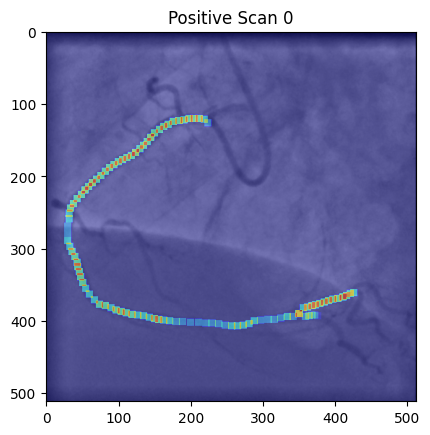

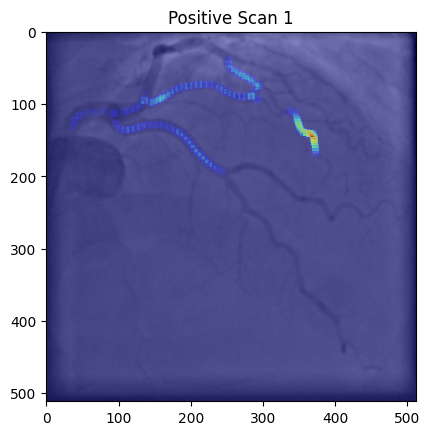

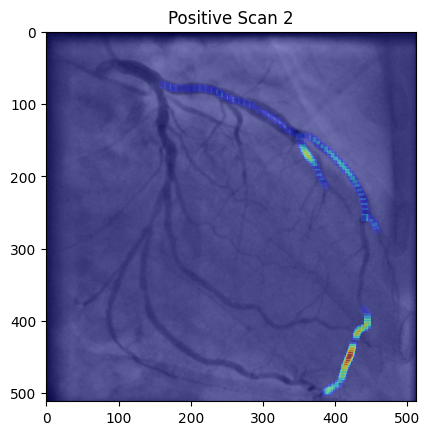

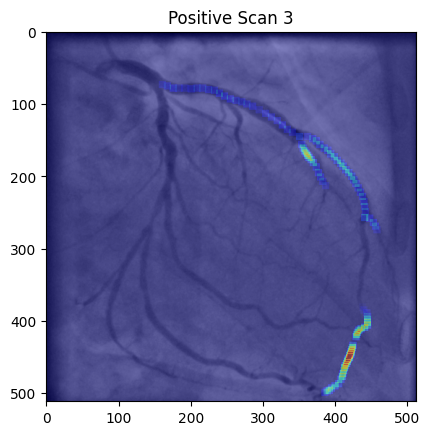

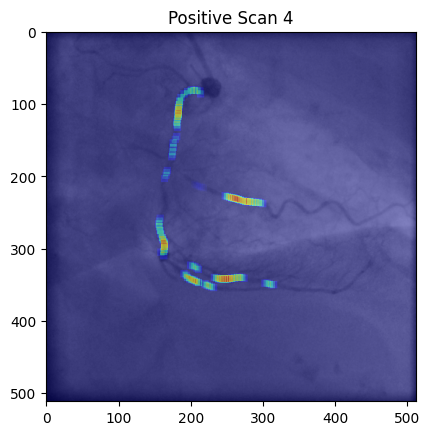

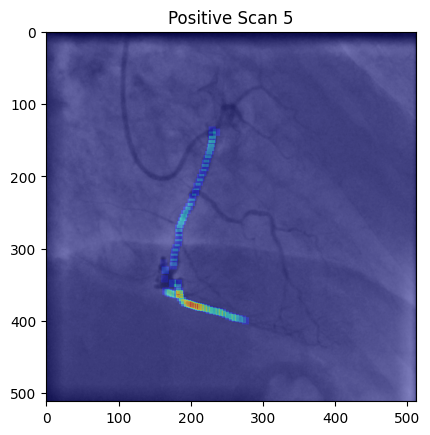

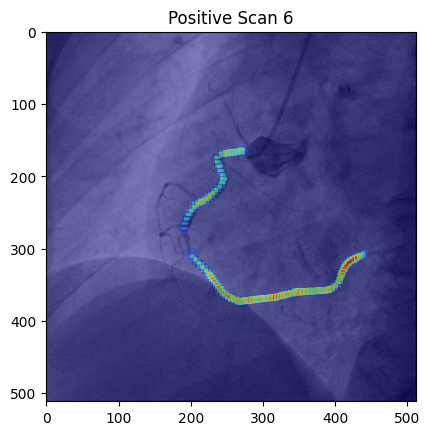

In [16]:
from collections import Counter 


for i, scan in enumerate(get_positive_scans(cfg)):
    transform = tv.transforms.ToTensor()
    images, anchors = get_images_and_anchors(scan, size=32)
    imgs = th.stack([transform(img) for img in images])
    # votes = count_votes(model.model.eval(), imgs, anchors, batch=32)
    votes = Counter([tuple(anchor) for anch_in_img in anchors[:100] for anchor in anch_in_img[:20]])
    plt.title(f"Positive Scan {i}")
    plot_votes(votes, scan.scan, size=10)
    if i > 5: break 